In [ ]:
!wget --no-check-certificate https://drive.google.com/uc?id=1xD33gESZ-8zT6xjLuUe7gkkOxkY32H1y -O flower.tif
!wget --no-check-certificate https://drive.google.com/uc?id=1_v63_-GZ-JfAqxgGVceQR69fOGyNUldb -O home.jpg
!wget --no-check-certificate https://drive.google.com/uc?id=1RjwqjawYV7kZPooNQ2MaubcTxLmShYmy -O bird.png

--2024-11-28 00:32:42--  https://drive.google.com/uc?id=1xD33gESZ-8zT6xjLuUe7gkkOxkY32H1y
Resolving drive.google.com (drive.google.com)... 108.177.121.139, 108.177.121.101, 108.177.121.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.121.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1xD33gESZ-8zT6xjLuUe7gkkOxkY32H1y [following]
--2024-11-28 00:32:43--  https://drive.usercontent.google.com/download?id=1xD33gESZ-8zT6xjLuUe7gkkOxkY32H1y
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.201.132, 2607:f8b0:4001:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.201.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5769832 (5.5M) [application/octet-stream]
Saving to: ‘flower.tif’

flower.tif          100%[===================>]   5.50M  27.5MB/s    in 0.2s    

2024-11-28 00:32:46 (27.5 MB/s)

In [ ]:
# importing necessary packages
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt

# 1. Color Histograms

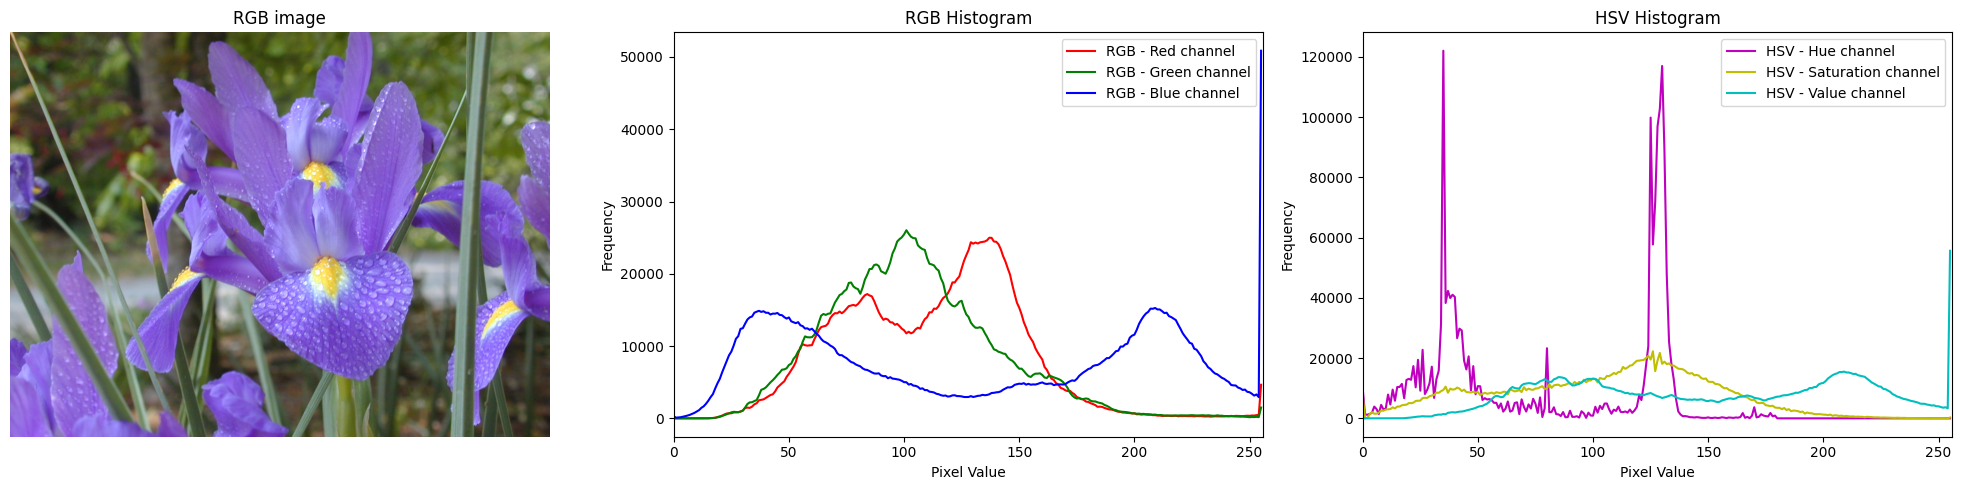

In [ ]:
image = cv2.imread('flower.tif')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Function to plot histograms
def plot_histogram(image, color_space_name, channels, colors):
    for i, (channel, color) in enumerate(zip(channels, colors)):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color, label=f"{color_space_name} - {channel} channel")
        plt.xlim([0, 256])
    plt.title(f"{color_space_name} Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    # plt.show()

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('RGB image')
plt.axis('off')

plt.subplot(1, 3, 2)
# Plot RGB histogram
plot_histogram(image_rgb, "RGB", ["Red", "Green", "Blue"], ["r", "g", "b"])

plt.subplot(1, 3, 3)
# Plot HSV histogram
plot_histogram(image_hsv, "HSV", ["Hue", "Saturation", "Value"], ["m", "y", "c"])

plt.tight_layout()
plt.show()

# 2. Dominant Colors Using Clustering

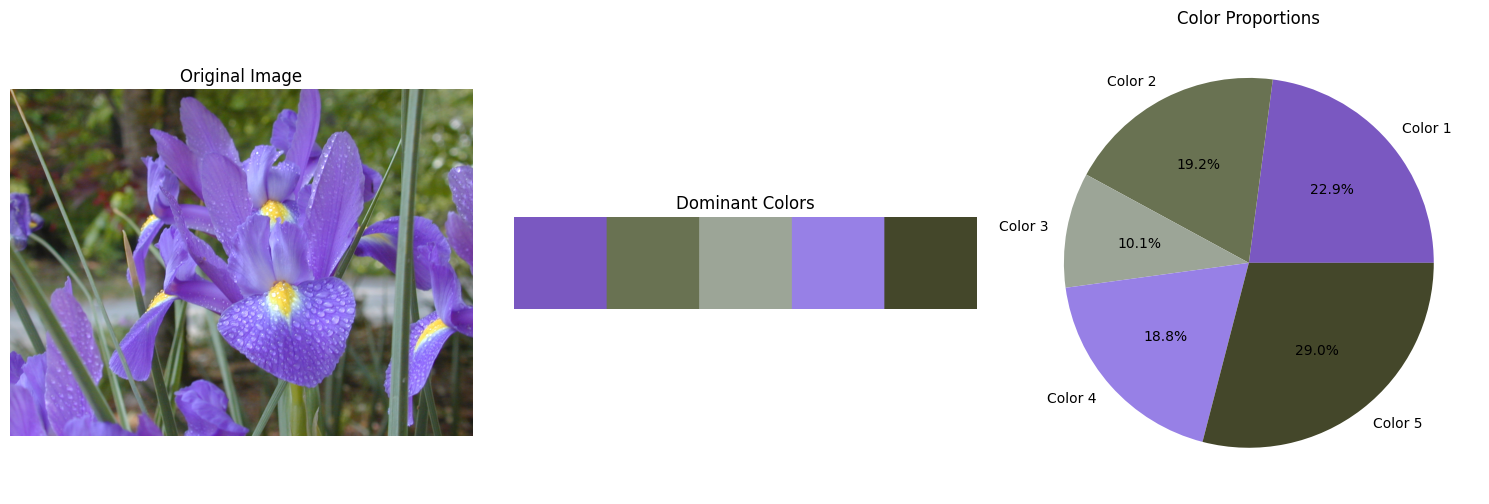

In [ ]:
from sklearn.cluster import KMeans

def dominant_colors_kmeans(image, n_clusters=5):

    # Reshape image into a 2D array of pixels (rows = pixels, columns = RGB values)
    pixels = image.reshape((-1, 3))

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)

    # Get cluster centers (dominant colors) and labels
    cluster_centers = kmeans.cluster_centers_.astype(int)  # RGB values
    labels = kmeans.labels_

    return cluster_centers, labels

def plot_dominant_colors(image, cluster_centers, labels):
    """
    Plot the original image, dominant colors, and a pie chart of color proportions.
    """
    # Create a figure
    plt.figure(figsize=(15, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")

    # Visualize dominant colors
    plt.subplot(1, 3, 2)
    dominant_colors_img = np.zeros((100, 100 * len(cluster_centers), 3), dtype="uint8")
    for i, color in enumerate(cluster_centers):
        dominant_colors_img[:, i * 100:(i + 1) * 100] = color
    plt.imshow(dominant_colors_img)
    plt.axis("off")
    plt.title("Dominant Colors")

    # Pie chart of proportions
    plt.subplot(1, 3, 3)
    unique, counts = np.unique(labels, return_counts=True)
    proportions = counts / labels.shape[0]
    plt.pie(proportions, labels=[f"Color {i+1}" for i in range(len(cluster_centers))],
            colors=np.array(cluster_centers) / 255, autopct='%1.1f%%')
    plt.title("Color Proportions")

    plt.tight_layout()
    plt.show()

# Load the image and convert to RGB
image_path = "flower.tif"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Find dominant colors
n_clusters = 5  # Number of dominant colors
cluster_centers, labels = dominant_colors_kmeans(image_rgb, n_clusters)

# Plot results
plot_dominant_colors(image_rgb, cluster_centers, labels)


# 3. Spatial Sensitivity with Color Auto-Correlogram

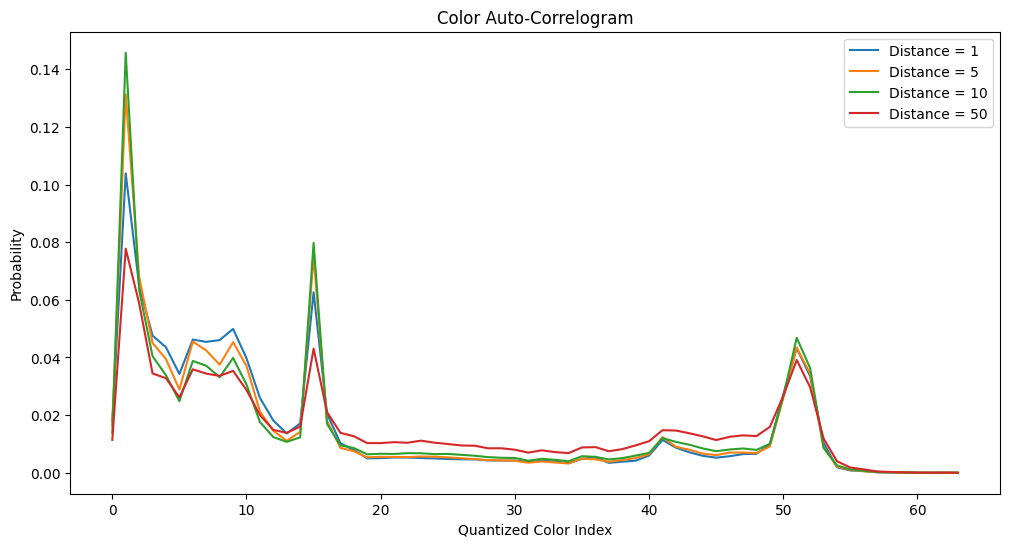

In [ ]:
def calculate_auto_correlogram(image, quantization_levels=64, distances=[1, 3, 5]):

    # Convert image to quantized colors
    quantized_image = quantize_colors(image, quantization_levels)

    # Initialize the correlogram dictionary
    correlogram = {}
    height, width = quantized_image.shape[:2]

    for d in distances:
        # Create an empty histogram for this distance
        hist = np.zeros(quantization_levels, dtype=np.float32)

        # Iterate through the image pixels
        for i in range(height):
            for j in range(width):
                current_color = quantized_image[i, j]

                # Check neighbors at distance d
                for di in [-d, 0, d]:
                    for dj in [-d, 0, d]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < height and 0 <= nj < width:
                            neighbor_color = quantized_image[ni, nj]
                            if neighbor_color == current_color:
                                hist[current_color] += 1

        # Normalize the histogram and add it to the correlogram
        correlogram[d] = hist / np.sum(hist)

    return correlogram

def quantize_colors(image, quantization_levels):
    """
    Quantize the colors in an image into a specified number of levels.
    """
    bins = np.linspace(0, 256, quantization_levels + 1, endpoint=True)
    quantized = np.digitize(image, bins) - 1
    quantized = quantized[..., 0]  # Use a single channel for quantization
    return quantized

# Plot correlogram
def plot_correlogram(correlogram, quantization_levels):
    plt.figure(figsize=(12, 6))
    for d, hist in correlogram.items():
        plt.plot(range(quantization_levels), hist, label=f"Distance = {d}")
    plt.title("Color Auto-Correlogram")
    plt.xlabel("Quantized Color Index")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()


# Load the image
image = cv2.imread('home.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Compute auto-correlogram
distances = [1, 5, 10, 50]  # Distances to analyze
quantization_levels = 64  # Number of color quantization levels
correlogram = calculate_auto_correlogram(image, quantization_levels, distances)

# Plot correlogram
plot_correlogram(correlogram, quantization_levels)


# 4. Illumination Effects and Histogram Equalization

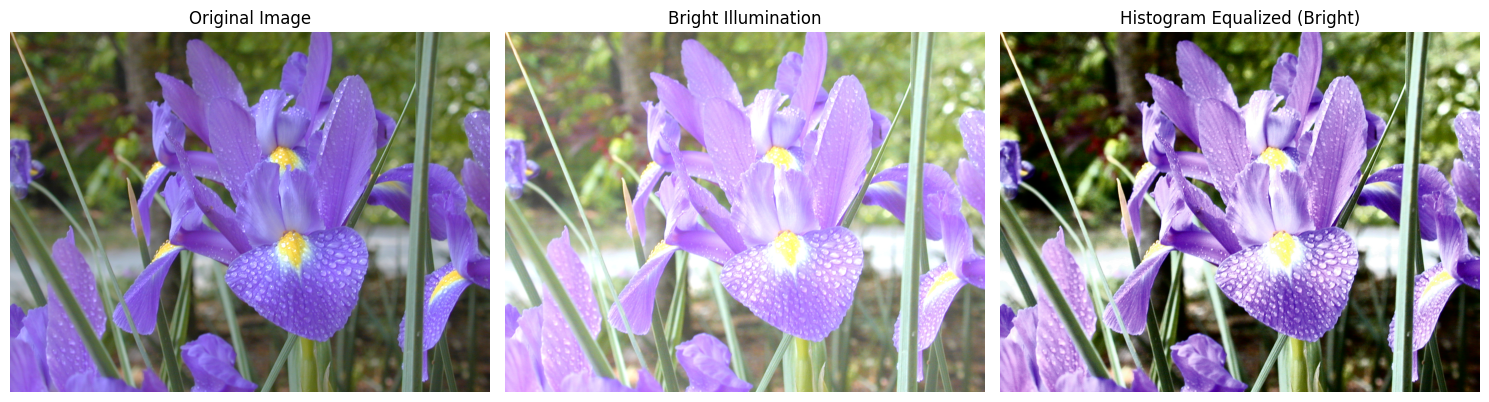

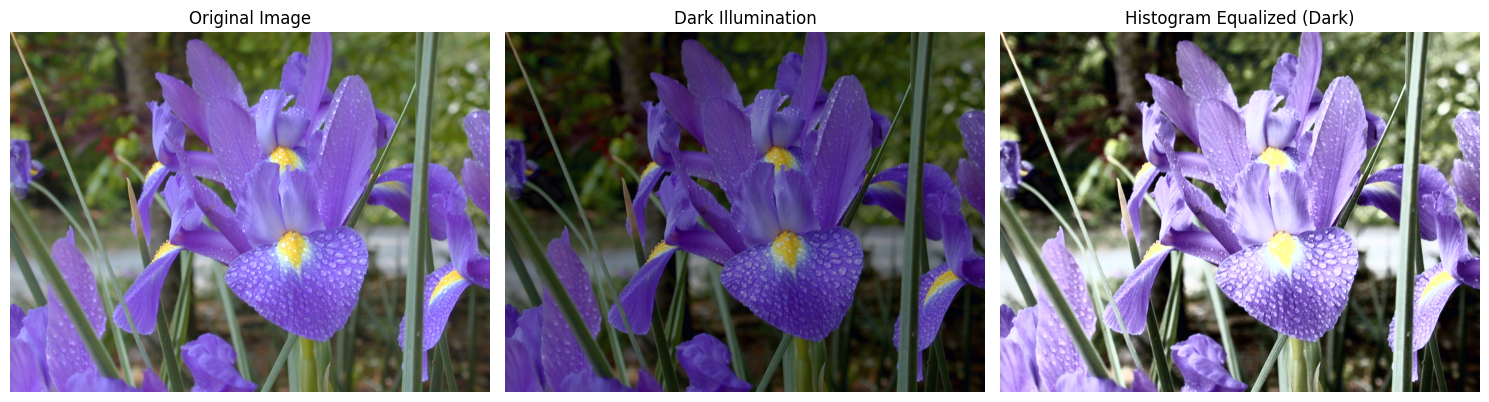

In [ ]:
def adjust_illumination(image, alpha, beta):
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

def apply_histogram_equalization(image):
    # Convert to YCrCb color space
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # Equalize the Y channel
    y, cr, cb = cv2.split(image_ycrcb)
    y_eq = cv2.equalizeHist(y)
    image_ycrcb_eq = cv2.merge((y_eq, cr, cb))

    # Convert back to RGB color space
    image_eq = cv2.cvtColor(image_ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    return image_eq

def display_images(images, titles):
    plt.figure(figsize=(15, 8))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Load the original image
image_path = "flower.tif"  # Replace with the path to your image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Simulate different illumination conditions
image_bright = adjust_illumination(image_rgb, alpha=1.2, beta=50)  # Bright image
image_dark = adjust_illumination(image_rgb, alpha=0.8, beta=-30)  # Dark image

# Apply histogram equalization
image_bright_eq = apply_histogram_equalization(image_bright)
image_dark_eq = apply_histogram_equalization(image_dark)

# Display results
display_images(
    [image_rgb, image_bright, image_bright_eq],
    ["Original Image", "Bright Illumination", "Histogram Equalized (Bright)"]
)

display_images(
    [image_rgb, image_dark, image_dark_eq],
    ["Original Image", "Dark Illumination", "Histogram Equalized (Dark)"]
)


# 5. Color Distribution Entropy (CDE)

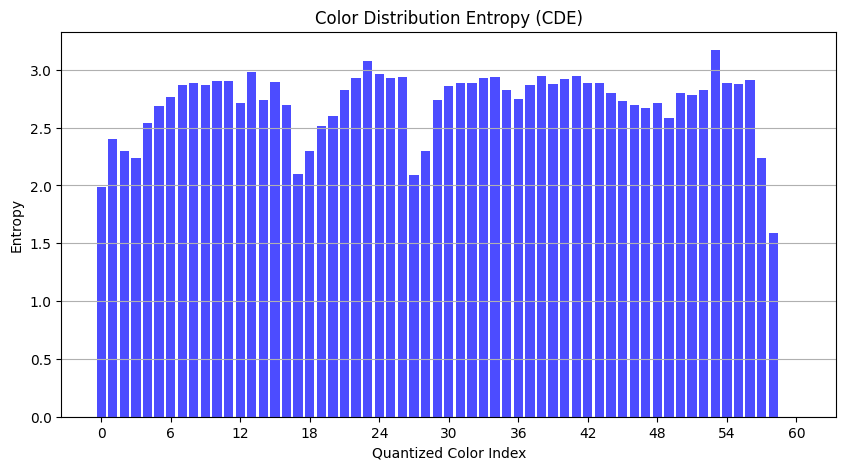

In [ ]:
def calculate_cde(image, quantization_levels=64):
    # Convert to grayscale for simplicity
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Quantize grayscale values
    bins = np.linspace(0, 256, quantization_levels + 1)
    quantized_image = np.digitize(gray_image, bins) - 1  # Quantized color indices

    # Initialize CDE dictionary
    cde_values = {}

    # Calculate CDE for each quantized color
    for color in range(quantization_levels):
        # Get the mask for the current color
        color_mask = (quantized_image == color).astype(np.uint8)

        # Find the centroid of the color region
        moments = cv2.moments(color_mask)
        if moments["m00"] == 0:  # Skip if no pixels of this color
            continue
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])

        # Calculate max distance to centroid
        coords = np.column_stack(np.where(color_mask > 0))
        distances = np.sqrt((coords[:, 1] - cx) ** 2 + (coords[:, 0] - cy) ** 2)
        max_distance = distances.max()

        # Create concentric rings and calculate pixel counts
        num_rings = 10  # Number of concentric rings
        ring_bins = np.linspace(0, max_distance, num_rings + 1)
        ring_counts = np.histogram(distances, bins=ring_bins)[0]

        # Normalize and calculate entropy
        total_count = ring_counts.sum()
        if total_count > 0:
            probabilities = ring_counts / total_count
            entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Add epsilon to avoid log(0)
            cde_values[color] = entropy

    return cde_values

def plot_cde(cde_values, quantization_levels):
    """
    Plot the CDE values for all quantized colors.
    """
    colors = list(cde_values.keys())
    entropies = list(cde_values.values())

    plt.figure(figsize=(10, 5))
    plt.bar(colors, entropies, color='blue', alpha=0.7)
    plt.title("Color Distribution Entropy (CDE)")
    plt.xlabel("Quantized Color Index")
    plt.ylabel("Entropy")
    plt.xticks(range(0, quantization_levels, max(1, quantization_levels // 10)))
    plt.grid(axis='y')
    plt.show()


# Load the image
image = cv2.imread("home.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Calculate CDE
quantization_levels = 64  # Number of color bins
cde_values = calculate_cde(image, quantization_levels)

# Plot CDE
plot_cde(cde_values, quantization_levels)


# 6. Color Layout Descriptor

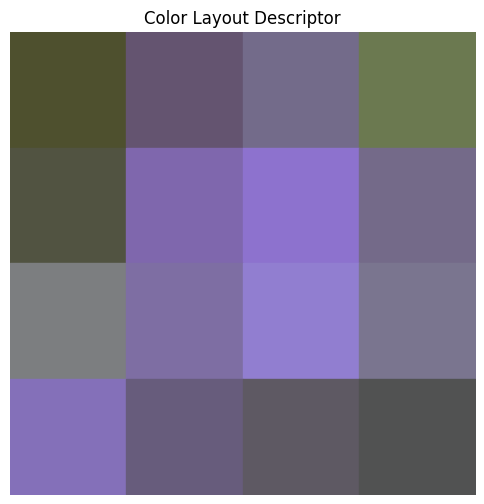

In [ ]:
def calculate_dominant_color(image, n_clusters=1):
    reshaped_image = image.reshape(-1, 3)  # Reshape to a 2D array of pixels
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_image)
    dominant_color = kmeans.cluster_centers_[0]
    return dominant_color

def compute_color_layout(image, grid_size=(4, 4)):
    height, width, _ = image.shape
    grid_colors = []

    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]

    for row in range(grid_size[0]):
        row_colors = []
        for col in range(grid_size[1]):
            # Extract the grid cell
            cell = image[row * cell_height:(row + 1) * cell_height,
                         col * cell_width:(col + 1) * cell_width]
            # Compute the dominant color of the cell
            dominant_color = calculate_dominant_color(cell, n_clusters=1)
            row_colors.append(dominant_color)
        grid_colors.append(row_colors)

    return np.array(grid_colors, dtype=np.uint8)

def plot_color_layout(grid_colors):
    grid_size = grid_colors.shape[:2]
    plt.figure(figsize=(6, 6))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            color = grid_colors[i, j] / 255.0  # Normalize for matplotlib
            plt.fill_between([j, j + 1], i, i + 1, color=color)
    plt.xlim(0, grid_size[1])
    plt.ylim(0, grid_size[0])
    plt.gca().invert_yaxis()
    plt.title("Color Layout Descriptor")
    plt.axis('off')
    plt.show()


# Load the image
image = cv2.imread("flower.tif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Compute color layout descriptor
grid_size = (4, 4)  # Define the grid size
grid_colors = compute_color_layout(image, grid_size=grid_size)

# Plot the color layout descriptor
plot_color_layout(grid_colors)


# 7. Color Moments

In [ ]:
def compute_color_moments(image):
    # Initialize a dictionary to store moments for each channel
    moments = {}

    # Compute moments for each channel
    channels = ['Red', 'Green', 'Blue']
    for i, channel in enumerate(channels):
        # Extract the channel
        data = image[:, :, i].flatten()

        # Calculate moments
        mean = np.mean(data)
        variance = np.var(data)
        skewness = np.mean((data - mean) ** 3) / (np.std(data) ** 3 + 1e-6)  # Add small value to avoid division by zero

        moments[channel] = {
            'Mean': mean,
            'Variance': variance,
            'Skewness': skewness
        }

    return moments

def display_color_moments(moments):
    for channel, stats in moments.items():
        print(f"{channel} Channel:")
        for moment_name, value in stats.items():
            print(f"  {moment_name}: {value:.2f}")
        print()

# Example Usage
image_path = 'flower.tif'  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

color_moments = compute_color_moments(image)
display_color_moments(color_moments)

Red Channel:
  Mean: 112.47
  Variance: 1383.42
  Skewness: 0.19

Green Channel:
  Mean: 103.79
  Variance: 1282.04
  Skewness: 0.62

Blue Channel:
  Mean: 131.05
  Variance: 5895.15
  Skewness: 0.05



# 8. Simple Shape Descriptors

Area: 95932.5
Perimeter: 3776.192114710808
Compactness (Circularity): 0.08
Rectangularity: 0.56
Major Axis Length: 137.84
Minor Axis Length: 98.64
Eccentricity: 1.40
Convex Hull Area: 169708.0
Convexity: 0.57


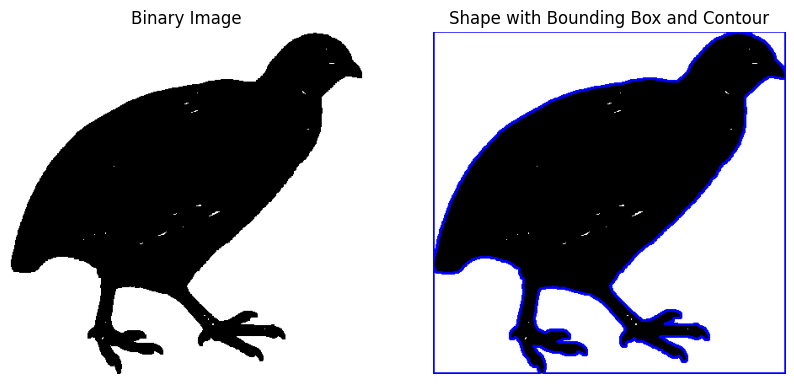

In [ ]:

binary_image = cv2.imread("bird.png", cv2.IMREAD_GRAYSCALE)

binary_image = cv2.bitwise_not(binary_image)

# Find the contours
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour corresponds to the bird
contour = max(contours, key=cv2.contourArea)
points = np.squeeze(contour)

cov_matrix = np.cov(points.T)  # Covariance of x and y coordinates

# Calculate the eigenvalues of the covariance matrix
eigenvalues, _ = np.linalg.eig(cov_matrix)
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort eigenvalues in descending order

# Calculate eccentricity (ratio of major to minor axis)
major_axis = np.sqrt(eigenvalues[0])  # Major axis length
minor_axis = np.sqrt(eigenvalues[1])  # Minor axis length
eccentricity = major_axis / minor_axis

# Compute Basic Shape Descriptors
area = cv2.contourArea(contour)
perimeter = cv2.arcLength(contour, closed=True)
compactness = (4 * np.pi * area) / (perimeter ** 2)
x, y, w, h = cv2.boundingRect(contour)
bounding_box_area = w * h
rectangularity = area / bounding_box_area

convex_hull = cv2.convexHull(contour)
hull_area = cv2.contourArea(convex_hull)

if hull_area > 0:  # Avoid division by zero
    convexity = area / hull_area
else:
    convexity = 0

# Print results
print(f"Area: {area}")
print(f"Perimeter: {perimeter}")
print(f"Compactness (Circularity): {compactness:.2f}")
print(f"Rectangularity: {rectangularity:.2f}")
print(f"Major Axis Length: {major_axis:.2f}")
print(f"Minor Axis Length: {minor_axis:.2f}")
print(f"Eccentricity: {eccentricity:.2f}")
print(f"Convex Hull Area: {hull_area}")
print(f"Convexity: {convexity:.2f}")

# Visualize the results
output_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
cv2.drawContours(output_image, [contour], -1, (0, 0, 255), 2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Binary Image")
plt.imshow(binary_image, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Shape with Bounding Box and Contour")
plt.imshow(output_image)
plt.axis("off")
plt.show()


# 9. Shape Histogram

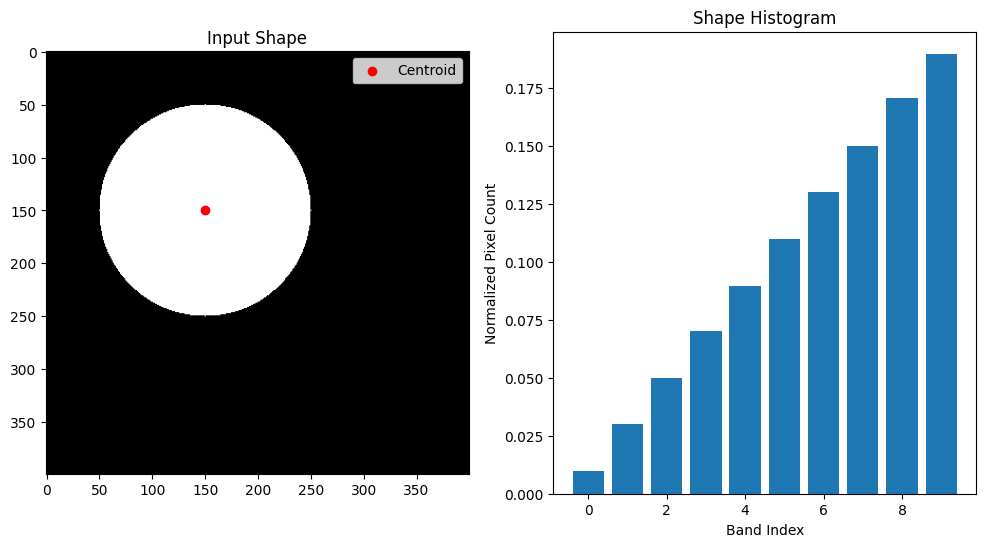

In [ ]:
def shape_histogram(image, num_bins=10):
    # Ensure the image is binary
    binary = (image > 0).astype(np.uint8)

    # Compute the centroid of the shape
    M = cv2.moments(binary)
    if M['m00'] == 0:  # Avoid division by zero
        raise ValueError("The binary image does not contain any shapes.")
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # Compute the maximum radius
    y_indices, x_indices = np.where(binary > 0)
    distances = np.sqrt((x_indices - cx)**2 + (y_indices - cy)**2)
    max_radius = np.max(distances)

    # Create bins for the histogram
    bins = np.linspace(0, max_radius, num_bins + 1)
    histogram = np.zeros(num_bins)

    # Assign each pixel to a bin
    for x, y in zip(x_indices, y_indices):
        r = np.sqrt((x - cx)**2 + (y - cy)**2)
        for i in range(num_bins):
            if bins[i] <= r < bins[i + 1]:
                histogram[i] += 1
                break

    # Normalize the histogram
    histogram /= np.sum(histogram)

    return histogram, cx, cy, bins


# Create a test binary image with a circle
img = np.zeros((400, 400), dtype=np.uint8)
cv2.circle(img, (150, 150), 100, 255, -1)  # Draw a filled circle

# Compute the shape histogram
histogram, cx, cy, bins = shape_histogram(img)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.scatter([cx], [cy], color='red', label='Centroid')
plt.title("Input Shape")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(len(histogram)), histogram, width=0.8, align='center')
plt.xlabel("Band Index")
plt.ylabel("Normalized Pixel Count")
plt.title("Shape Histogram")
plt.show()


# 10. Chain Code

Chain Code: [1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 

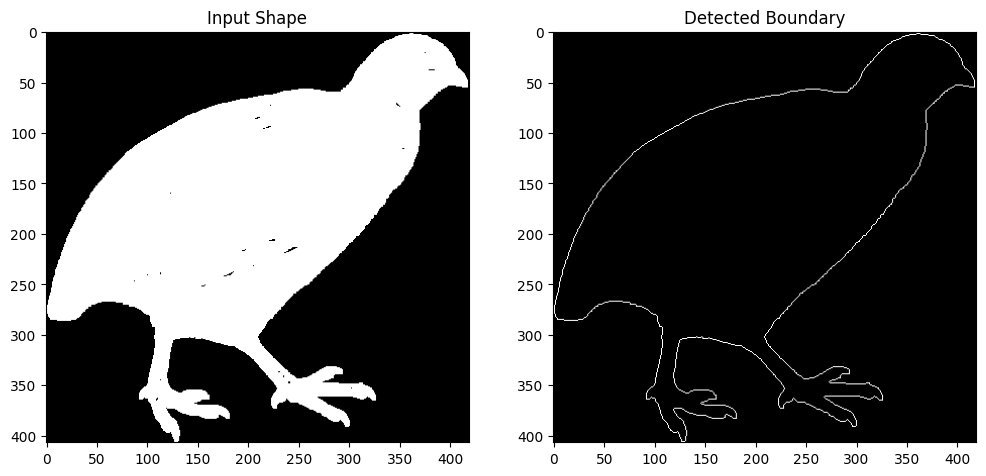

In [ ]:
def chain_code(binary_image):
    # Ensure the image is binary
    binary = (binary_image > 0).astype(np.uint8)

    # Find the contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
        raise ValueError("No contours found in the image.")

    # Get the largest contour (assuming a single shape)
    contour = max(contours, key=len).squeeze()

    # Define direction vectors for 8-connectivity
    directions = [
        (0, 1),   # 0: Right
        (-1, 1),  # 1: Up-Right
        (-1, 0),  # 2: Up
        (-1, -1), # 3: Up-Left
        (0, -1),  # 4: Left
        (1, -1),  # 5: Down-Left
        (1, 0),   # 6: Down
        (1, 1),   # 7: Down-Right
    ]

    # Calculate chain code
    chain = []
    for i in range(len(contour) - 1):
        diff = tuple(contour[i + 1] - contour[i])
        direction = directions.index(diff)
        chain.append(direction)


    # Calculate derivative of the chain code
    derivative = [(chain[i + 1] - chain[i]) % 8 for i in range(len(chain) - 1)]

    # Create a boundary image for visualization
    boundary_image = np.zeros_like(binary)
    for point in contour:
        boundary_image[point[1], point[0]] = 255

    return chain, derivative, boundary_image



img = cv2.imread("bird.png", cv2.IMREAD_GRAYSCALE)

# Compute chain code
chain, derivative, boundary_img = chain_code(img)

# Print chain code
print("Chain Code:", chain)
print("Derivative of chain Code:", derivative)

# Visualize the boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Input Shape")

plt.subplot(1, 2, 2)
plt.imshow(boundary_img, cmap="gray")
plt.title("Detected Boundary")
plt.show()


# 11. Fourier Descriptors

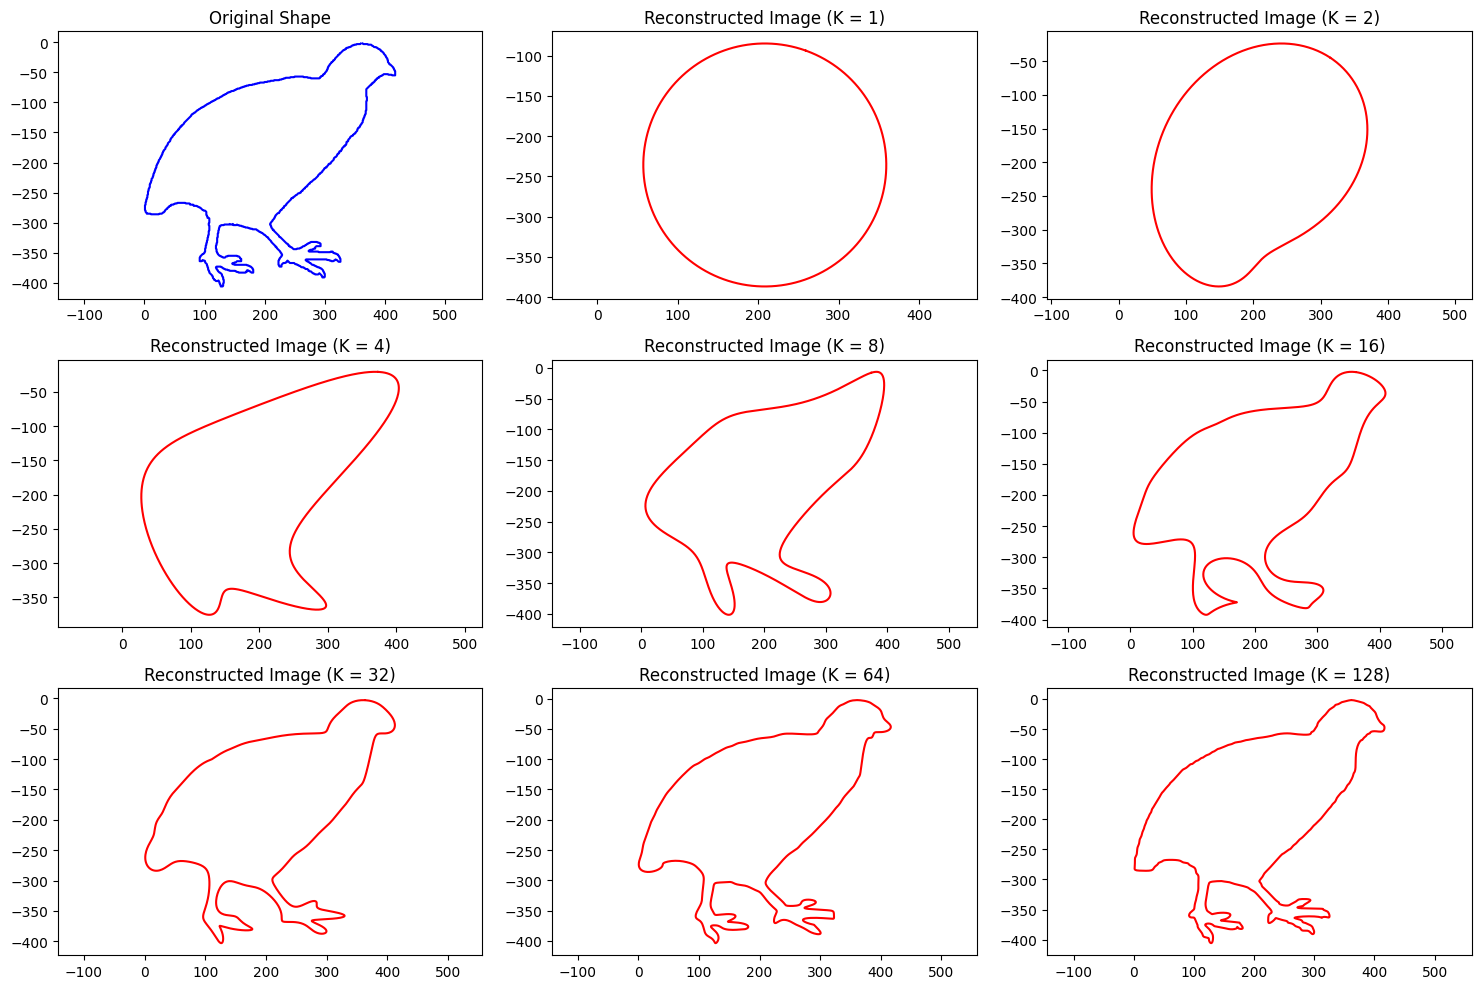

In [ ]:
def fourier_descriptors(contour, num_descriptors=20):
    # Flatten contour points and create complex numbers
    contour = contour.squeeze()
    complex_contour = contour[:, 0] + 1j * contour[:, 1]

    # Perform Discrete Fourier Transform (DFT)
    dft = np.fft.fft(complex_contour)

    # Zero out high-frequency components
    dft[num_descriptors:-num_descriptors] = 0

    # Perform Inverse DFT to reconstruct contour
    reconstructed_contour = np.fft.ifft(dft)
    return np.real(reconstructed_contour), np.imag(reconstructed_contour), dft

# Load the image
image_path = "bird.png"  # Replace with the path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Threshold the image to create a binary mask
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Process the largest contour (assuming the object of interest is prominent)
contour = max(contours, key=cv2.contourArea)

# Compute Fourier Descriptors
num_descriptors = 20  # Adjust to retain more or fewer low-frequency components
x_reconstructed, y_reconstructed, dft = fourier_descriptors(contour, num_descriptors=num_descriptors)

# Numbers of descriptors to compare
descriptor_counts = [1, 2, 4, 8, 16, 32, 64, 128]

# Plotting
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
plt.plot(contour[:, 0, 0], -contour[:, 0, 1], 'b-', label="Original Shape")
plt.title("Original Shape")
plt.axis('equal')

for i, num_descriptors in enumerate(descriptor_counts):
    x_reconstructed, y_reconstructed, _ = fourier_descriptors(contour, num_descriptors)
    plt.subplot(3, 3, i + 2)
    plt.plot(x_reconstructed, -y_reconstructed, 'r-', label=f"{num_descriptors} Descriptors")
    plt.title(f"Reconstructed Image (K = {num_descriptors})")
    plt.axis('equal')

plt.tight_layout()
plt.show()

# 12. Moments and Hu’s Invariants

Raw Moments:
m00: 18578790.0
m10: 3728196900.0
m01: 3392991240.0
m20: 915327955470.0
m11: 609641495565.0
m02: 761820410610.0
m30: 251681776563870.0
m21: 134654726801055.0
m12: 131262116147535.0
m03: 194705169072180.0
mu20: 167192467358.57782
mu11: -71228433138.38464
mu02: 142168132139.94153
mu30: 902488833840.57
mu21: -3922246586342.9043
mu12: 4404468591477.84
mu03: 3648569930422.0493

Hu's Invariant Moments:
Hu[1]: 8.962520e-04
Hu[2]: 1.755883e-07
Hu[3]: 1.758227e-10
Hu[4]: 1.275726e-11
Hu[5]: -2.998564e-22
Hu[6]: 1.461569e-15
Hu[7]: -5.245304e-22


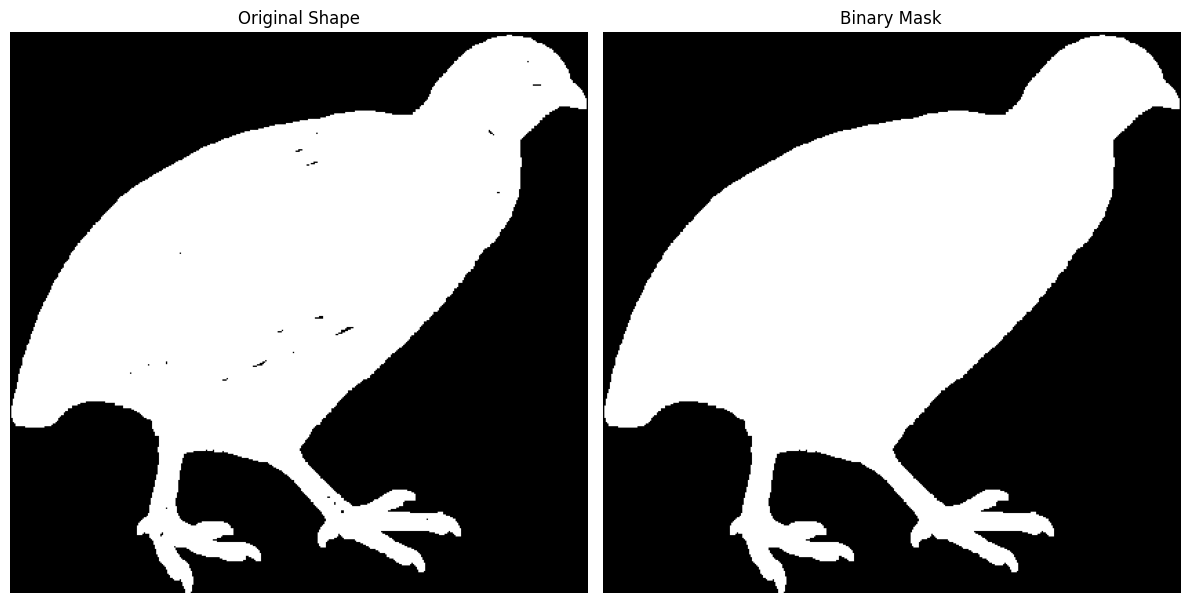

In [ ]:
# Load the image
image_path = "bird.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Threshold the image to create a binary mask
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Process the largest contour (assuming the object of interest is prominent)
contour = max(contours, key=cv2.contourArea)

# Create a binary mask for the contour
mask = np.zeros_like(binary)
cv2.drawContours(mask, [contour], -1, 255, thickness=-1)

# Calculate Moments
moments = cv2.moments(mask)

# Extract and print raw moments
print("Raw Moments:")
for key, value in moments.items():
    if key.startswith("m"):
        print(f"{key}: {value}")

# Compute and print Hu's invariant moments
hu_moments = cv2.HuMoments(moments).flatten()
print("\nHu's Invariant Moments:")
for i, moment in enumerate(hu_moments):
    print(f"Hu[{i + 1}]: {moment:.6e}")


plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Shape")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Binary Mask")
plt.axis('off')

plt.tight_layout()
plt.show()